In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout, Flatten

In [2]:
df = pd.read_csv("bitstampUSD_1-min_data_2012-01-01_to_2019-03-13.csv")
df = df.dropna()
df.head(10)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
478,1325346600,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000
547,1325350740,4.50,4.57,4.50,4.57,37.862297,171.380338,4.526411
548,1325350800,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000
1224,1325391360,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000
1896,1325431680,4.84,4.84,4.84,4.84,10.000000,48.400000,4.840000
2333,1325457900,5.00,5.00,5.00,5.00,10.100000,50.500000,5.000000
3612,1325534640,5.00,5.00,5.00,5.00,19.048000,95.240000,5.000000
4553,1325591100,5.32,5.32,5.32,5.32,2.419173,12.870000,5.320000
4710,1325600520,5.14,5.14,5.14,5.14,0.680000,3.495200,5.140000


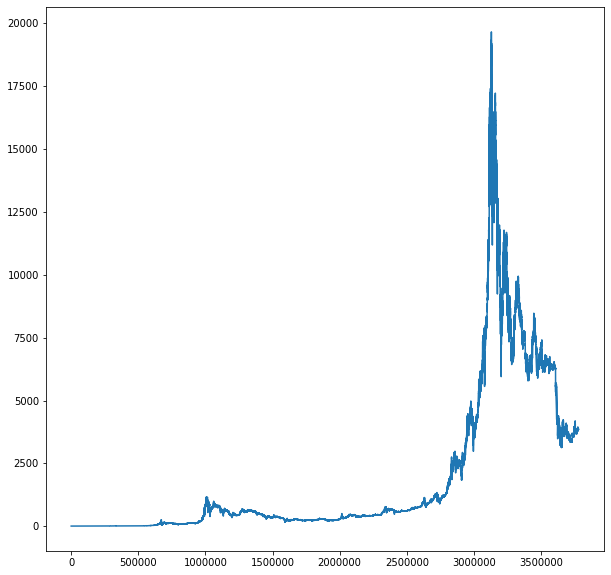

In [3]:
price = df['Weighted_Price']
plt.figure(figsize=(10,10))
plt.plot(price)

In [4]:
timestep = 60
price_train = price[:len(price)-timestep]
price_test = price[len(price)-timestep:]


In [5]:
def scale_data(data):
    sc = MinMaxScaler(feature_range=(0,1))
    return sc.fit_transform(data),sc

In [6]:
price_train = price_train.values.reshape(price_train.shape[0],1)
price_train_scaled, training_scale_model = scale_data(price_train)

price_test = price_test.values.reshape(price_test.shape[0],1)
price_test_scaled, test_scale_model = scale_data(price_test)

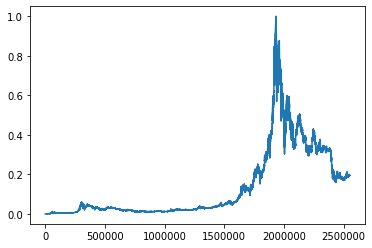

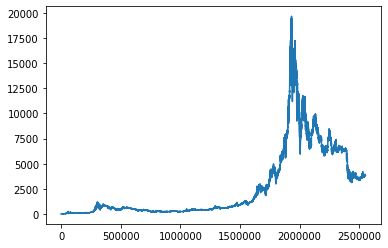

In [7]:
plt.plot(price_train_scaled)# plot scaled training set
plt.figure()
plt.plot(training_scale_model.inverse_transform(price_train_scaled)) # plot inversed scaled training set

In [8]:
def build_timeseries(data,step):
    X = []
    Y = []
    
    for i in range(len(data)-step-1):
        X.append(data[i:i+step,0])
        Y.append(data[i+step,0])
    X = np.array(X)
    Y = np.array(Y)
    return X,Y
    

In [9]:
X_train, Y_train = build_timeseries(price_train_scaled,step = 10)
X_test, Y_test = build_timeseries(price_test_scaled,step = 10)

In [10]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
X_train.shape

(2551061, 10, 1)

In [11]:
model = Sequential()
model.add(SimpleRNN(200,activation='relu',return_sequences=True,input_shape=(10,1)))
model.add(Dropout(0.1))
model.add(SimpleRNN(150,activation='relu',return_sequences=True))
model.add(Dropout(0.1))
model.add(SimpleRNN(100,activation= 'relu',return_sequences=True))
model.add(Dropout(0.1))
model.add(SimpleRNN(150,activation='relu',return_sequences=True))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(8, activation="relu")) 
model.add(Dense(units = 1))
model.summary()
model.compile(optimizer='adam',loss= 'mean_squared_error')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 10, 200)           40400     
_________________________________________________________________
dropout (Dropout)            (None, 10, 200)           0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 10, 150)           52650     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 150)           0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 10, 100)           25100     
_________________________________________________________________
dropout_2 (Dropout)  

In [12]:
trained_RNN_model = model.fit(X_train,Y_train,epochs=5)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
2551061/2551061 [==============================] - 2534s 993us/sample - loss: 4.3622e-05
Epoch 2/5
2551061/2551061 [==============================] - 2512s 985us/sample - loss: 2.1867e-05
Epoch 3/5
2551061/2551061 [==============================] - 2566s 1ms/sample - loss: 1.8974e-05
Epoch 4/5
2551061/2551061 [==============================] - 2662s 1ms/sample - loss: 1.7654e-05
Epoch 5/5
2551061/2551061 [==============================] - 2421s 949us/sample - loss: 1.6294e-05


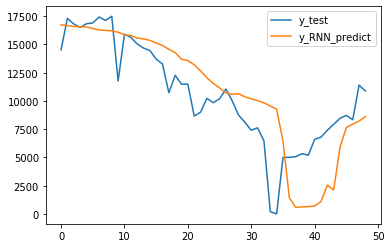

In [14]:
Y_RNN_predicted = model.predict(X_test)
plt.plot(training_scale_model.inverse_transform(Y_test.reshape(-1, 1)))
plt.plot(training_scale_model.inverse_transform(Y_RNN_predicted))
plt.legend(['y_test', 'y_RNN_predict'])

In [15]:
LSTM_model = Sequential()
LSTM_model.add(LSTM(200, input_shape=(10, 1),return_sequences= True))
LSTM_model.add(Dropout(0.2))
LSTM_model.add(LSTM(100))
LSTM_model.add(Dropout(0.2))
LSTM_model.add(Dense(20,activation='relu'))
LSTM_model.add(Dropout(0.2))
LSTM_model.add(Dense(1))
LSTM_model.summary()
LSTM_model.compile(optimizer='adam',loss= 'mean_squared_error')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 200)           161600    
_________________________________________________________________
dropout_4 (Dropout)          (None, 10, 200)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               120400    
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                2020      
_________________________________________________________________
dropout_6 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total para

In [16]:
trained_LSTM_model = LSTM_model.fit(X_train,Y_train,epochs=3)

Epoch 1/3
2551061/2551061 [==============================] - 5795s 2ms/sample - loss: 0.0010
Epoch 2/3
2551061/2551061 [==============================] - 5786s 2ms/sample - loss: 9.5535e-04
Epoch 3/3
2551061/2551061 [==============================] - 5996s 2ms/sample - loss: 9.4067e-04


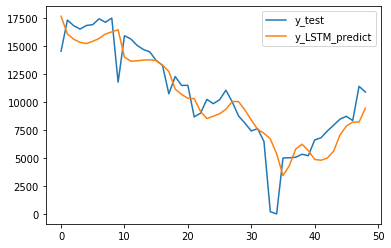

In [17]:
Y_LSTM_predicted = LSTM_model.predict(X_test)
plt.plot(training_scale_model.inverse_transform(Y_test.reshape(-1, 1)))
plt.plot(training_scale_model.inverse_transform(Y_LSTM_predicted))
plt.legend(['y_test', 'y_LSTM_predict'])